## Logic for importing data dynamically

In [2249]:
import pandas as pd
import numpy as np
from pypots.imputation import SAITS
from pypots.optim import Adam
import random
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tsmoothie.smoother import LowessSmoother
import math

## Loading and inspecting the data 

In [2250]:
def load_file(file_path, file_type):
    """
    Loads a CSV or XLSX file and returns it as a pandas DataFrame.
    """
    try:
        if file_type.lower() == 'csv':
            df = pd.read_csv(file_path)
        elif file_type.lower() == 'xlsx':
            df = pd.read_excel(file_path)
        else:
            raise ValueError("Unsupported file type. Please use 'csv' or 'xlsx'.")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

In [2251]:
df_filtered = load_file("Gasifier Data Sets/filtered_combine_data.csv", "csv")
df_useful = load_file("Gasifier Data Sets/only_useful_columns.csv","csv")
df_RD241203 = load_file("Gasifier Data Sets/RD241203.csv","csv")


In [2252]:
df_filtered.head()

,Date,Time,EFG Air Flow Rate lb/hr,Primary O2 Flow Rate lb/hr,EFG System Pressure psi,Slurry Flow Rate lb/hr,Injector Cooling Water Outlet Temp F,EFG:EFG_Oxygen_Pressure_1.Value,EFG:EFG_Oxygen_Pressure_2.Value,Analyzer 2 CO2 %,...,GB CH4%,GB H2%,GB C2H4%,GB C2H2%,GB LHV [MJ/Nm3],Afterburner Air Flow Rate lb/hr,Afterburner Natural Gas Flow Rate lb/hr,EFG Quenched Gas Temp F,EFG:B_TC_1_Shallow.Value,EFG:B_TC_4_Shallow.Value
0,12/3/2024,1:39:07 PM,15.750,49.488,13.401,57.01,77.0,292.012,42.300,2.031,...,0.004,-0.052,0.108,0.004,-5.475,129.348,7.110,116.421,2285.612,2282.151
1,12/3/2024,1:39:12 PM,15.754,48.725,14.528,58.26,77.0,292.425,42.075,1.956,...,0.004,-0.052,0.099,0.004,-5.465,128.621,7.178,116.994,2289.086,2285.197
2,12/3/2024,1:39:17 PM,15.578,50.975,15.582,56.26,77.0,291.675,44.325,1.894,...,0.003,-0.052,0.098,0.004,-5.495,129.050,7.125,117.915,2292.515,2288.074
3,12/3/2024,1:39:22 PM,15.921,51.000,16.563,55.80,77.0,291.713,44.625,1.829,...,0.004,-0.052,0.098,0.004,-5.485,129.861,7.136,118.567,2295.820,2290.951
4,12/3/2024,1:39:27 PM,15.751,50.950,17.690,56.48,77.0,291.900,45.225,1.774,...,0.004,-0.026,0.089,0.004,-5.490,129.769,7.198,118.828,2299.463,2293.996


In [2253]:
df_useful.head()

,Date,Time,GB H2%,GB CO%,EFG:B_TC_1_Shallow.Value


In [2254]:
df_RD241203.head(10)

,Date,Time,EFG Air Flow Rate lb/hr,EFG Gas Flow Rate lb/hr,Primary O2 Flow Rate lb/hr,Secondary O2 Flow Rate lb/hr,EFG System Pressure psi,EFG Reactor dP inH2O,Moyno Flow Rate lb/hr,EFG:EFG_Oxygen_Pressure_1.Value,...,EFG:EFG_Air_Valve.Value,EFG:EFG_Gas_Valve.Value,EFG:EFG_Badger_CV_Setpoint.Value,EFG:quench_bath_recirc_VFD.Value,EFG:Large_Netzch_Set_Point.Value,EFG:EFG_Moyno_Pump_VFD.Value,EFG:Bldg_566_City_Water_Pressure.Value,EFG:Purge_Reading.Value,EFG:Post_AB_O2.Value,Recirc_VFD_Amps
0,12/3/2024,1:39:07 PM,15.750,0.218,49.488,-0.003,13.401,-0.128,57.01,292.012,...,2213.425,2226.637,57.01,77.287,0,0,35,40,0,0
1,12/3/2024,1:39:12 PM,15.754,0.000,48.725,-0.003,14.528,-0.143,58.26,292.425,...,2213.253,2227.324,58.26,77.199,0,0,35,40,0,0
2,12/3/2024,1:39:17 PM,15.578,0.000,50.975,-0.003,15.582,-0.135,56.26,291.675,...,2213.253,2228.010,56.26,77.199,0,0,35,40,0,0
3,12/3/2024,1:39:22 PM,15.921,0.000,51.000,-0.003,16.563,-0.135,55.80,291.713,...,2213.082,2229.040,55.80,77.463,0,0,35,40,0,0
4,12/3/2024,1:39:27 PM,15.751,0.000,50.950,-0.003,17.690,-0.143,56.48,291.900,...,2212.738,2230.069,56.48,77.331,0,0,35,40,0,0
5,12/3/2024,1:39:33 PM,15.753,0.218,50.625,-0.003,19.071,-0.128,56.82,292.088,...,2212.738,2231.099,56.82,77.331,0,0,35,40,0,0
6,12/3/2024,1:39:38 PM,15.753,0.218,50.300,-0.003,20.198,-0.143,56.49,291.900,...,2212.738,2232.129,56.49,77.331,0,0,35,40,0,0
7,12/3/2024,1:39:42 PM,15.752,0.000,50.112,-0.003,21.361,-0.158,55.45,291.750,...,2212.393,2233.158,55.45,77.463,0,0,35,40,0,0
8,12/3/2024,1:39:47 PM,15.755,0.000,49.988,-0.003,22.488,-0.135,57.21,291.713,...,2212.218,2234.016,57.21,77.331,0,0,35,40,0,0
9,12/3/2024,1:39:52 PM,15.755,0.000,50.100,-0.003,23.542,-0.128,56.16,291.938,...,2212.218,2235.217,56.16,77.507,0,0,32,40,0,0


In [2255]:
df_RD241203.dtypes

Date                                           object
Time                                           object
EFG Air Flow Rate lb/hr                       float64
EFG Gas Flow Rate lb/hr                       float64
Primary O2 Flow Rate lb/hr                    float64
Secondary O2 Flow Rate lb/hr                  float64
EFG System Pressure psi                       float64
EFG Reactor dP inH2O                          float64
Moyno Flow Rate lb/hr                         float64
EFG:EFG_Oxygen_Pressure_1.Value               float64
EFG:EFG_Oxygen_Pressure_2.Value               float64
EFG:Ballast_Reading.Value                     float64
EFG:Ballast_SP.Value                            int64
EFG:HOB_Fuel_Reading.Value                    float64
EFG:HOB_Fuel_SP.Value                           int64
EFG:HOB_CW_In.Value                             int64
EFG:Hot_Hold_HSR                              float64
EFG:HSR                                       float64
EFG:HOB_Peeper.State        

In [2256]:
# Create datetime
df_RD241203['datetime'] = pd.to_datetime(
    df_RD241203['Date'] + ' ' + df_RD241203['Time'],
    format='%m/%d/%Y %I:%M:%S %p'
)

# Drop Date and Time columns from the dataframe
df_RD241203 = df_RD241203.drop(columns=['Date', 'Time'])

# Also drop Date and Time columns from the useful columns list
df_useful = df_useful.drop(columns=['Date', 'Time'])

In [2257]:
def are_columns_present(df_subset, df_full):
    """
    Returns True if all columns in df_subset are present in df_full.
    """
    return set(df_subset.columns).issubset(set(df_full.columns))

In [2258]:
result = are_columns_present(df_useful, df_RD241203)
print(result)

True


## inputing real industrial time series data

**Missing Data Scenarios in High-Frequency Industrial Time Series**

In high-frequency industrial time series data, missing values can take different forms from different operational and technical events. Understanding the cause and pattern of missing data is crucial for effective data cleaning and modeling. Our current data set is from **Utah’s Advanced Energy Systems Research,” and it is clean and has no missing values. We will introduce missing data into the dataset, but we will also attempt to model real-life examples of missing data in industrial time series data.

Below are six realistic scenarios where missing data may occur, along with a description of how they typically manifest in the dataset:

1. **Short Sensor Malfunction**  
   - A single sensor malfunction, causing isolated `NaN` values in one column for a few consecutive timestamps.
   
2. **Network Malfunctions**  
   - A network interruption may cause multiple rows to be missing completely, resulting in noticeable gaps in the timestamp sequence.

3. **Maintenance Pause**  
   - Planned maintenance routines may lead to extended periods where specific sensors consistently record zeros or `NaN`.

4. **Sensor Error with Placeholder Values**  
   In the event a sensor fails, instead of stopping the data recording, the device may send extreme out-of-range values (e.g., `-9999`, `9999`, `1e6`) as placeholders for missing or invalid readings. These must be detected and treated as missing during the preprocessing stage.

5. **Time Desynchronization**  
   - System clock drift or timestamp misalignment can cause duplicate, missing, or out-of-order timestamps within the data.

6. **Catastrophic System Event**  
   - Major system failures, such as machines breaking down, can cause a loss of data across multiple sensors simultaneously.

Each scenario represents different missing values in the dataset and must be addressed carefully, taking into account the next steps in ‘cleanits’.




In [2259]:
def inputing_missing_values(df_useful, df_clean):
    df = df_clean.copy()

    # --- BUILD DATETIME (infer format, coerce errors) ---
    # if 'Date' in df.columns and 'Time' in df.columns:
    #     df['datetime'] = pd.to_datetime(
    #         df['Date'] + ' ' + df['Time'],
    #         infer_datetime_format=True,
    #         errors='coerce'
    #     )
    #     # drop any rows where parsing failed
    #     df = df.dropna(subset=['datetime']).reset_index(drop=True)
    # else:
    #     raise ValueError("Expected 'Date' and 'Time' columns.")

    # sort & reset index
    df = df.sort_values('datetime').reset_index(drop=True)

    # only the useful columns that exist, but never Date/Time
    target_cols = [c for c in df_useful.columns if c in df.columns]

    # mask to track injected NaNs
    missing_mask = pd.DataFrame(False, index=df.index, columns=target_cols)
    rng = np.random.default_rng(seed=42)
    scenario_map = {}
    total_nan_injected = 0

    print("\n--- Injecting Missing Data ---")

    # 1) Short Sensor Glitch
    for _ in range(3):
        col = random.choice(target_cols)
        row = rng.integers(10, len(df) - 10)
        df.loc[row:row+2, col] = np.nan
        missing_mask.loc[row:row+2, col] = True
        for r in range(row, row+3):
            scenario_map[(r, col)] = 'short_glitch'
        print(f"[Short Glitch] Injected NaNs at rows {row}-{row+2} in column '{col}'")
        total_nan_injected += 3

    # 2) Network Malfunction (drop 3 consecutive rows)
    for _ in range(2):
        if len(df) > 10:
            available = df.index[10:-10]
            row = int(rng.choice(available))
            drop_rows = list(range(row, row+3))
            valid = [r for r in drop_rows if r in df.index]
            for r in valid:
                for col in target_cols:
                    scenario_map[(r, col)] = 'network'
            df = df.drop(index=valid).reset_index(drop=True)
            missing_mask = missing_mask.drop(index=valid).reset_index(drop=True)
            print(f"[Network Malfunction] Dropped rows {row}-{row+2}")

    # 3) Maintenance Pause
    for _ in range(3):
        col = random.choice(target_cols)
        if len(df) > 50:
            row = rng.integers(0, len(df)-50)
            use_zero = rng.choice([True, False])
            if use_zero:
                df.loc[row:row+30, col] = 0.0
                for r in range(row, row+31):
                    scenario_map[(r, col)] = 'maintenance'
                print(f"[Maintenance Pause] Injected 0s at rows {row}-{row+30} in '{col}'")
            else:
                df.loc[row:row+30, col] = np.nan
                missing_mask.loc[row:row+30, col] = True
                for r in range(row, row+31):
                    scenario_map[(r, col)] = 'maintenance'
                print(f"[Maintenance Pause] Injected NaNs at rows {row}-{row+30} in '{col}'")
                total_nan_injected += 31

    # 4) Placeholder Errors
    for _ in range(3):
        col = random.choice(target_cols)
        row = rng.integers(0, len(df)-5)
        placeholder = random.choice([-9999, 9999, 1e6])
        df.loc[row, col] = placeholder
        missing_mask.loc[row, col] = True
        scenario_map[(row, col)] = 'placeholder'
        print(f"[Sensor Error] Inserted placeholder {placeholder} at row {row} in '{col}'")

    # 5) Time Desync
    for _ in range(3):
        idx = rng.integers(1, len(df)-2)
        if rng.choice([True, False]):
            df.loc[idx, 'datetime'] = df.loc[idx+1, 'datetime']
            scenario_map[(idx, 'datetime')] = 'time_desync'
            print(f"[Time Desync] Row {idx} datetime ← row {idx+1}")
        else:
            df.loc[idx, 'datetime'] = df.loc[idx-1, 'datetime']
            scenario_map[(idx, 'datetime')] = 'time_desync'
            print(f"[Time Desync] Row {idx} datetime ← row {idx-1}")

    # 6) Catastrophic Event
    for _ in range(2):
        size = min(5, len(target_cols))
        cols = rng.choice(target_cols, size=size, replace=False)
        if len(df) > 20:
            row = rng.integers(0, len(df)-20)
            for col in cols:
                df.loc[row:row+10, col] = np.nan
                missing_mask.loc[row:row+10, col] = True
                for r in range(row, row+11):
                    scenario_map[(r, col)] = 'catastrophic'
            print(f"[Catastrophic Event] Injected NaNs at rows {row}-{row+10} in {cols}")
            total_nan_injected += 11 * size

    print(f"\n--- Total injected ≈ {total_nan_injected} NaNs ---\n")
    return df, missing_mask, scenario_map


In [2260]:
def replace_placeholders(df, target_cols, placeholders=[-9999, 9999, 1e6]):
    for col in target_cols:
        if np.issubdtype(df[col].dtype, np.number):
            df[col] = df[col].replace(placeholders, np.nan)
    return df

In [2261]:
df_corrupted, missing_mask, scenario_map = inputing_missing_values(df_useful, df_RD241203)
target_cols = [col for col in df_useful.columns if col in df_corrupted.columns]
for col in target_cols:
    if col in df_corrupted.columns:
        df_corrupted[col] = pd.to_numeric(df_corrupted[col], errors='coerce')
df_corrupted = replace_placeholders(df_corrupted, target_cols)


--- Injecting Missing Data ---
[Short Glitch] Injected NaNs at rows 146-148 in column 'GB CO%'
[Short Glitch] Injected NaNs at rows 1194-1196 in column 'EFG:B_TC_1_Shallow.Value'
[Short Glitch] Injected NaNs at rows 1012-1014 in column 'GB CO%'
[Network Malfunction] Dropped rows 681-683
[Network Malfunction] Dropped rows 671-673
[Maintenance Pause] Injected 0s at rows 1283-1313 in 'EFG:B_TC_1_Shallow.Value'
[Maintenance Pause] Injected 0s at rows 1042-1072 in 'GB CO%'
[Maintenance Pause] Injected NaNs at rows 140-170 in 'GB CO%'
[Sensor Error] Inserted placeholder -9999 at row 1502 in 'GB CO%'
[Sensor Error] Inserted placeholder 9999 at row 1133 in 'GB H2%'
[Sensor Error] Inserted placeholder 1000000.0 at row 1172 in 'GB CO%'
[Time Desync] Row 1107 datetime ← row 1106
[Time Desync] Row 792 datetime ← row 793
[Time Desync] Row 1295 datetime ← row 1296
[Catastrophic Event] Injected NaNs at rows 1191-1201 in ['EFG:B_TC_1_Shallow.Value' 'GB CO%' 'GB H2%']
[Catastrophic Event] Injected NaN

In [2262]:
injected_cols = set([col for (_, col), glitch in scenario_map.items() if col in df_corrupted.columns])
print(f"\n[SUMMARY] Injected glitches affected {len(injected_cols)} columns:")
for col in sorted(injected_cols):
    print(f" - {col}")


[SUMMARY] Injected glitches affected 4 columns:
 - EFG:B_TC_1_Shallow.Value
 - GB CO%
 - GB H2%
 - datetime


In [2263]:
print("Column dtypes before coercion:")
print(df_corrupted[target_cols].dtypes)

Column dtypes before coercion:
GB H2%                      float64
GB CO%                      float64
EFG:B_TC_1_Shallow.Value    float64
dtype: object


## Checking if the self imputed missing values actually work

In [2264]:
missing_summary = df_corrupted.isna().sum()
print(missing_summary[missing_summary > 0])

GB CO%                      58
GB H2%                      23
EFG:B_TC_1_Shallow.Value    25
dtype: int64


In [2265]:
df_simulated = df_corrupted.sort_values('datetime').reset_index(drop=True)
time_diffs = df_simulated['datetime'].diff().dt.total_seconds()
print(time_diffs[time_diffs > 5])

5        6.0
11       6.0
16       6.0
18       6.0
19       6.0
29       6.0
36       6.0
42       6.0
47       6.0
51       6.0
55       6.0
58       6.0
62       6.0
69       6.0
71       6.0
74       6.0
81       6.0
84       6.0
100      6.0
103      6.0
105      6.0
110      6.0
116      6.0
119      6.0
123      6.0
127      6.0
132      6.0
136      6.0
140      6.0
144      6.0
150      6.0
158      6.0
161      6.0
168      6.0
170      6.0
173      6.0
179      6.0
188      6.0
192      6.0
194      6.0
199      6.0
206      6.0
210      6.0
216      6.0
223      6.0
231      6.0
234      6.0
242      7.0
250      6.0
254      6.0
260      6.0
262      6.0
267      6.0
274      6.0
281      6.0
285      6.0
289      6.0
294      6.0
296      6.0
298      6.0
303      6.0
307      6.0
310      6.0
316      6.0
327      6.0
330      6.0
336      6.0
342      6.0
348      6.0
355      6.0
361      6.0
366      6.0
375      6.0
377      6.0
380      6.0
382      6.0
390      6.0

In [2266]:
target_cols = [col for col in df_useful.columns if col in df_corrupted.columns]

placeholders = [-9999, 9999, 1e6]
for val in placeholders:
    hits = (df_corrupted[target_cols] == val).sum()
    print(f"Placeholder {val} found in columns:")
    print(hits[hits > 0])

Placeholder -9999 found in columns:
Series([], dtype: int64)
Placeholder 9999 found in columns:
Series([], dtype: int64)
Placeholder 1000000.0 found in columns:
Series([], dtype: int64)


In [2267]:
duplicates = df_simulated['datetime'].duplicated().sum()
print(f"Number of duplicated timestamps: {duplicates}")

Number of duplicated timestamps: 3


In [2268]:
# ===========================================
# Global evaluation function for pipelines
# ===========================================
def evaluate_imputation(df_true, df_pred, missing_mask, target_cols):
    """
    Evaluate imputation performance only on originally missing positions.
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    all_true = []
    all_pred = []

    for col in target_cols:
        mask = missing_mask[col]

        true_col = df_true[col][mask]
        pred_col = df_pred[col][mask]

        valid = ~np.isnan(true_col.values) & ~np.isnan(pred_col.values)
        true_valid = true_col.values[valid]
        pred_valid = pred_col.values[valid]

        all_true.extend(true_valid)
        all_pred.extend(pred_valid)

    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    mae = mean_absolute_error(all_true, all_pred)
    rmse = mean_squared_error(all_true, all_pred) ** 0.5
    r2 = r2_score(all_true, all_pred)

    print("\n--- Evaluation ---")
    print(f"Number of points evaluated: {len(all_true)}")
    print(f"True values sample: {all_true[:5]}")
    print(f"Predicted values sample: {all_pred[:5]}")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


## Creating helper functions that will help look for and diagnose each of the six scenarios described above.

In [2269]:
def detect_short_nan_blocks(series, max_gap=3):
    """Detect short isolated NaN blocks in a column."""
    is_nan = series.isna()
    groups = (is_nan != is_nan.shift()).cumsum()
    sizes = is_nan.groupby(groups).sum()
    mask = is_nan & groups.map(lambda x: sizes[x] <= max_gap)
    return mask

def detect_time_gaps(df, expected_seconds=5):
    """Detect rows where time gap exceeds expected frequency."""
    time_diffs = df['datetime'].diff().dt.total_seconds()
    gap_indices = time_diffs[time_diffs > expected_seconds].index
    return gap_indices

def detect_long_blocks(series, min_length=20, zero_included=True):
    """Detect long blocks of NaN or zeros."""
    if zero_included:
        invalid = series.isna() | (series == 0)
    else:
        invalid = series.isna()
    groups = (invalid != invalid.shift()).cumsum()
    sizes = invalid.groupby(groups).sum()
    mask = invalid & groups.map(lambda x: sizes[x] >= min_length)
    return mask

def detect_placeholder_values(df, target_cols, placeholders=[-9999, 9999, 1e6]):
    """Detect placeholder values in dataframe."""
    placeholder_hits = {}
    for col in target_cols:
        hits = df[col].isin(placeholders)
        if hits.any():
            placeholder_hits[col] = hits
    return placeholder_hits

def detect_time_desync(df):
    """Detect duplicated or non-monotonic timestamps."""
    duplicated = df['datetime'].duplicated()
    non_monotonic = df['datetime'].diff().dt.total_seconds() < 0
    return duplicated | non_monotonic

def detect_catastrophic_blocks(df, target_cols, min_cols=5, min_rows=10):
    """Detect blocks where many columns go NaN simultaneously."""
    block_mask = (df[target_cols].isna().sum(axis=1) >= min_cols)
    block_groups = (block_mask != block_mask.shift()).cumsum()
    block_sizes = block_mask.groupby(block_groups).sum()
    true_blocks = block_mask & block_groups.map(lambda x: block_sizes[x] >= min_rows)
    return true_blocks

def impute_interpolate(df, col):
    """Interpolates missing values in a single column using datetime index."""
    df = df.copy()
    df = df.set_index('datetime')
    df[col] = df[col].interpolate(method='time')
    df = df.reset_index()
    return df

def impute_fill_zero_or_median(df, col):
    """Fill long blocks with median or zero depending on content."""
    if df[col].median() != 0:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(0)
    return df

def impute_knn(df, target_cols, n_neighbors=5):
    """
    Apply KNN imputation only to numeric columns that contain some NaNs
    and at least one non-NaN value.
    """
    numeric_cols = [col for col in target_cols if np.issubdtype(df[col].dtype, np.number)]

    cols_with_nans = [col for col in numeric_cols if 0 < df[col].isna().sum() < len(df)]

    if not cols_with_nans:
        return df

    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_values = imputer.fit_transform(df[cols_with_nans])

    imputed_df = pd.DataFrame(imputed_values, columns=cols_with_nans, index=df.index)
    df[cols_with_nans] = imputed_df
    return df


## Logic to handle each of the six scenarios.

In [2270]:
def handle_short_sensor_glitch(df, target_cols, scenario_map, verbose=True):
    affected = [(row, col) for (row, col), glitch in scenario_map.items() if glitch == 'short_glitch']
    if not affected:
        if verbose:
            print("[Short Sensor Glitch] No injected short glitches found.")
        return df

    from collections import defaultdict
    col_rows = defaultdict(set)
    for row, col in affected:
        if col in df.columns:
            col_rows[col].add(row)

    for col, rows in col_rows.items():
        if df[col].isna().sum() == 0:
            continue
        if verbose:
            print(f"[Short Sensor Glitch] Interpolating {len(rows)} points in '{col}'")
        df = impute_interpolate(df, col)

    return df

def handle_network_malfunction(df, target_cols, scenario_map, verbose=True):
    """Only refill the two injected 3-row drops (~20s gaps)."""
    time_diffs = df['datetime'].diff().dt.total_seconds()

    # pick only the big injected holes (4–5 intervals of 5s)
    expected = 5
    gap_indices = time_diffs[
        (time_diffs > expected * 4) &
        (time_diffs < expected * 5)
    ].index

    if verbose:
        print(f"[Network] will refill {len(gap_indices)} injected gaps at {gap_indices.tolist()}")

    if not len(gap_indices):
        if verbose:
            print("[Network] no injected gaps to refill.")
        return df

    for idx in sorted(gap_indices, reverse=True):
        prev_t = df.loc[idx-1, 'datetime']
        next_t = df.loc[idx,   'datetime']
        fill_t = prev_t + pd.Timedelta(seconds=expected)
        while fill_t < next_t:
            new_row = df.iloc[[idx-1]].copy()
            new_row['datetime'] = fill_t
            new_row[target_cols] = np.nan
            df = pd.concat([df.iloc[:idx], new_row, df.iloc[idx:]]).reset_index(drop=True)
            fill_t += pd.Timedelta(seconds=expected)
            idx += 1

    return df



def handle_maintenance_pause(df, target_cols, scenario_map, verbose=True):
    """Fix rows that were part of maintenance pauses (NaNs or zeros) based on scenario_map."""
    from collections import defaultdict

    maintenance_rows = defaultdict(set)
    for (row, col), glitch in scenario_map.items():
        if glitch == 'maintenance' and col in df.columns:
            maintenance_rows[col].add(row)

    if not maintenance_rows:
        if verbose:
            print("[Maintenance Pause] No maintenance events found.")
        return df

    for col, rows in maintenance_rows.items():
        if not np.issubdtype(df[col].dtype, np.number):
            continue

        affected = df.loc[list(rows), col]
        if affected.isna().any() or (affected == 0).any():
            if verbose:
                print(f"[Maintenance Pause] {col}: Imputing {len(rows)} rows (NaNs or 0s).")
            df = impute_fill_zero_or_median(df, col)

    return df

def handle_sensor_placeholder_values(df, target_cols, scenario_map=None, verbose=True):
    """
    Detect and replace placeholder values in target columns regardless of scenario_map.
    This makes the pipeline more robust in case scenario_map is missing or incomplete.
    """
    placeholders = [-9999, 9999, 1e6]
    for col in target_cols:
        if col in df.columns:
            mask = df[col].isin(placeholders)
            if mask.any():
                df.loc[mask, col] = np.nan
                df = impute_interpolate(df, col)
                if verbose:
                    print(f"[Sensor Placeholder] {col}: Placeholder values replaced and interpolated.")
    return df

def handle_time_desync(df, target_cols, scenario_map, verbose=True):
    """Fix only the rows that were affected by time desync events based on scenario map."""
    desync_rows = [row for (row, col), glitch_type in scenario_map.items() if glitch_type == 'time_desync']

    if not desync_rows:
        if verbose:
            print("[Time Desync] No time desync events found.")
        return df

    if verbose:
        print(f"[Time Desync] Fixing {len(desync_rows)} time desync rows.")

    df = df.sort_values('datetime').reset_index(drop=True)

    df = df.drop_duplicates(subset='datetime')
    return df

def handle_catastrophic_event(df, target_cols, scenario_map, verbose=True):
    """Fix blocks affected by catastrophic events ONLY."""
    catastrophic_rows = [row for (row, col), glitch_type in scenario_map.items() if glitch_type == 'catastrophic']

    if not catastrophic_rows:
        if verbose:
            print("[Catastrophic Event] No catastrophic events found.")
        return df

    block_mask = (df[target_cols].isna().sum(axis=1) >= 5)
    block_groups = (block_mask != block_mask.shift()).cumsum()
    block_sizes = block_mask.groupby(block_groups).sum()
    true_blocks = block_mask & block_groups.map(lambda x: block_sizes[x] >= 10)

    if true_blocks.any():
        rows_to_impute = df.index[true_blocks]
        affected_df = df.loc[rows_to_impute, target_cols]

        cols_to_use = [col for col in affected_df.columns if affected_df[col].isna().sum() > 0 and affected_df[col].notna().sum() > 0]

        if cols_to_use:
            imputer = KNNImputer(n_neighbors=5)
            imputed_array = imputer.fit_transform(affected_df[cols_to_use])

            imputed_df = pd.DataFrame(imputed_array, columns=cols_to_use, index=rows_to_impute)
            df.loc[rows_to_impute, cols_to_use] = imputed_df

            if verbose:
                print(f"[Catastrophic Event] Imputed {len(rows_to_impute)} rows across {len(cols_to_use)} columns using KNN.")

    return df



In [2271]:
def clean_all(df, target_cols, scenario_map, verbose=True):
    df = handle_short_sensor_glitch(df, target_cols, scenario_map, verbose)
    df = handle_network_malfunction(df, target_cols, scenario_map, verbose)
    df = handle_maintenance_pause(df, target_cols, scenario_map, verbose)
    df = handle_sensor_placeholder_values(df, target_cols, scenario_map, verbose)
    df = handle_time_desync(df, target_cols, scenario_map, verbose)
    df = handle_catastrophic_event(df, target_cols, scenario_map, verbose)

    if verbose:
        print("[Final Sweep] Applying simple bad fill (forward-fill + backward-fill)...")

    for col in target_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
    if verbose:
        print("[Anomaly] Running rolling-median and second-diff cleaning…")
    for col in target_cols:
        # first remove big outliers via rolling median
        df[col] = rolling_med_clean(df, col, window=7, quantile=0.95)
        # then remove spikes via second differences
        df[col] = second_diff_clean(df, col, quantile=0.95)
    # optional: global LOWESS smoothing pass
    if verbose:
        print("[Anomaly] Running LOWESS smoother…")
    smoothed = LowessSmoother(smooth_fraction=0.1, iterations=1)
    for col in target_cols:
        smoothed.smooth(df[col].values)
        df[col] = smoothed.smooth_data[0]

    # ===== final blanket fill =====
    if verbose:
        print("[Final Sweep] ffill + bfill…")
    for col in target_cols:
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

    return df

In [2272]:
import matplotlib.pyplot as plt

def plot_side_by_side(df_before, df_after, cols, datetime_col='datetime', figsize_per_row=(12,2)):
    """
    Plots each column in `cols` on its own row with two panels (BEFORE vs AFTER).
    Wider plots and rotated/adjusted y-labels.
    """
    n = len(cols)
    fig, axes = plt.subplots(n, 2, 
                             figsize=(figsize_per_row[0], figsize_per_row[1] * n),
                             sharex=True,
                             gridspec_kw={'width_ratios': [1, 1]})
    if n == 1:
        axes = axes.reshape(1,2)

    for i, col in enumerate(cols):
        if col not in df_before.columns or col not in df_after.columns:
            print(f"[SKIP] Column '{col}' not found in one of the dataframes.")
            continue
        if df_before[col].isna().all() or df_after[col].isna().all():
            print(f"[SKIP] Column '{col}' is all NaNs in before/after.")
            continue

        axb, axa = axes[i]
        # BEFORE
        axb.plot(df_before[datetime_col], df_before[col], linewidth=0.8)
        axb.set_title("BEFORE", fontsize=9)
        axb.set_ylabel(col, fontsize=7, rotation=0, labelpad=60, ha='right', va='center')
        axb.tick_params(labelsize=6)

        # AFTER
        axa.plot(df_after[datetime_col], df_after[col], linewidth=0.8)
        axa.set_title("AFTER", fontsize=9)
        axa.tick_params(labelsize=6, labelrotation=45)

        clean_vals = (
            pd.concat([
                df_before[col].replace([-9999,9999,1e6], np.nan),
                df_after[col]
            ])
            .dropna()
        )
        if not clean_vals.empty:
            mn, mx = clean_vals.min(), clean_vals.max()
            pad = (mx-mn)*0.05
            axb.set_ylim(mn-pad, mx+pad)
            axa.set_ylim(mn-pad, mx+pad)

    for ax in axes.flatten():
        ax.grid(True, alpha=0.3)
    print("Final target columns:", target_cols)

    fig.tight_layout(h_pad=1.5)
    plt.show()


[Short Sensor Glitch] Interpolating 3 points in 'GB CO%'
[Network] will refill 1 injected gaps at [678]
[Maintenance Pause] GB CO%: Imputing 62 rows (NaNs or 0s).
[Maintenance Pause] EFG:B_TC_1_Shallow.Value: Imputing 31 rows (NaNs or 0s).
[Time Desync] Fixing 3 time desync rows.
[Final Sweep] Applying simple bad fill (forward-fill + backward-fill)...
[Anomaly] Running rolling-median and second-diff cleaning…
[Anomaly] Running LOWESS smoother…


C:\Users\randy\AppData\Local\Temp\ipykernel_5516\4074044224.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


[Final Sweep] ffill + bfill…
Final target columns: ['GB H2%', 'GB CO%', 'EFG:B_TC_1_Shallow.Value']


C:\Users\randy\AppData\Local\Temp\ipykernel_5516\4074044224.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


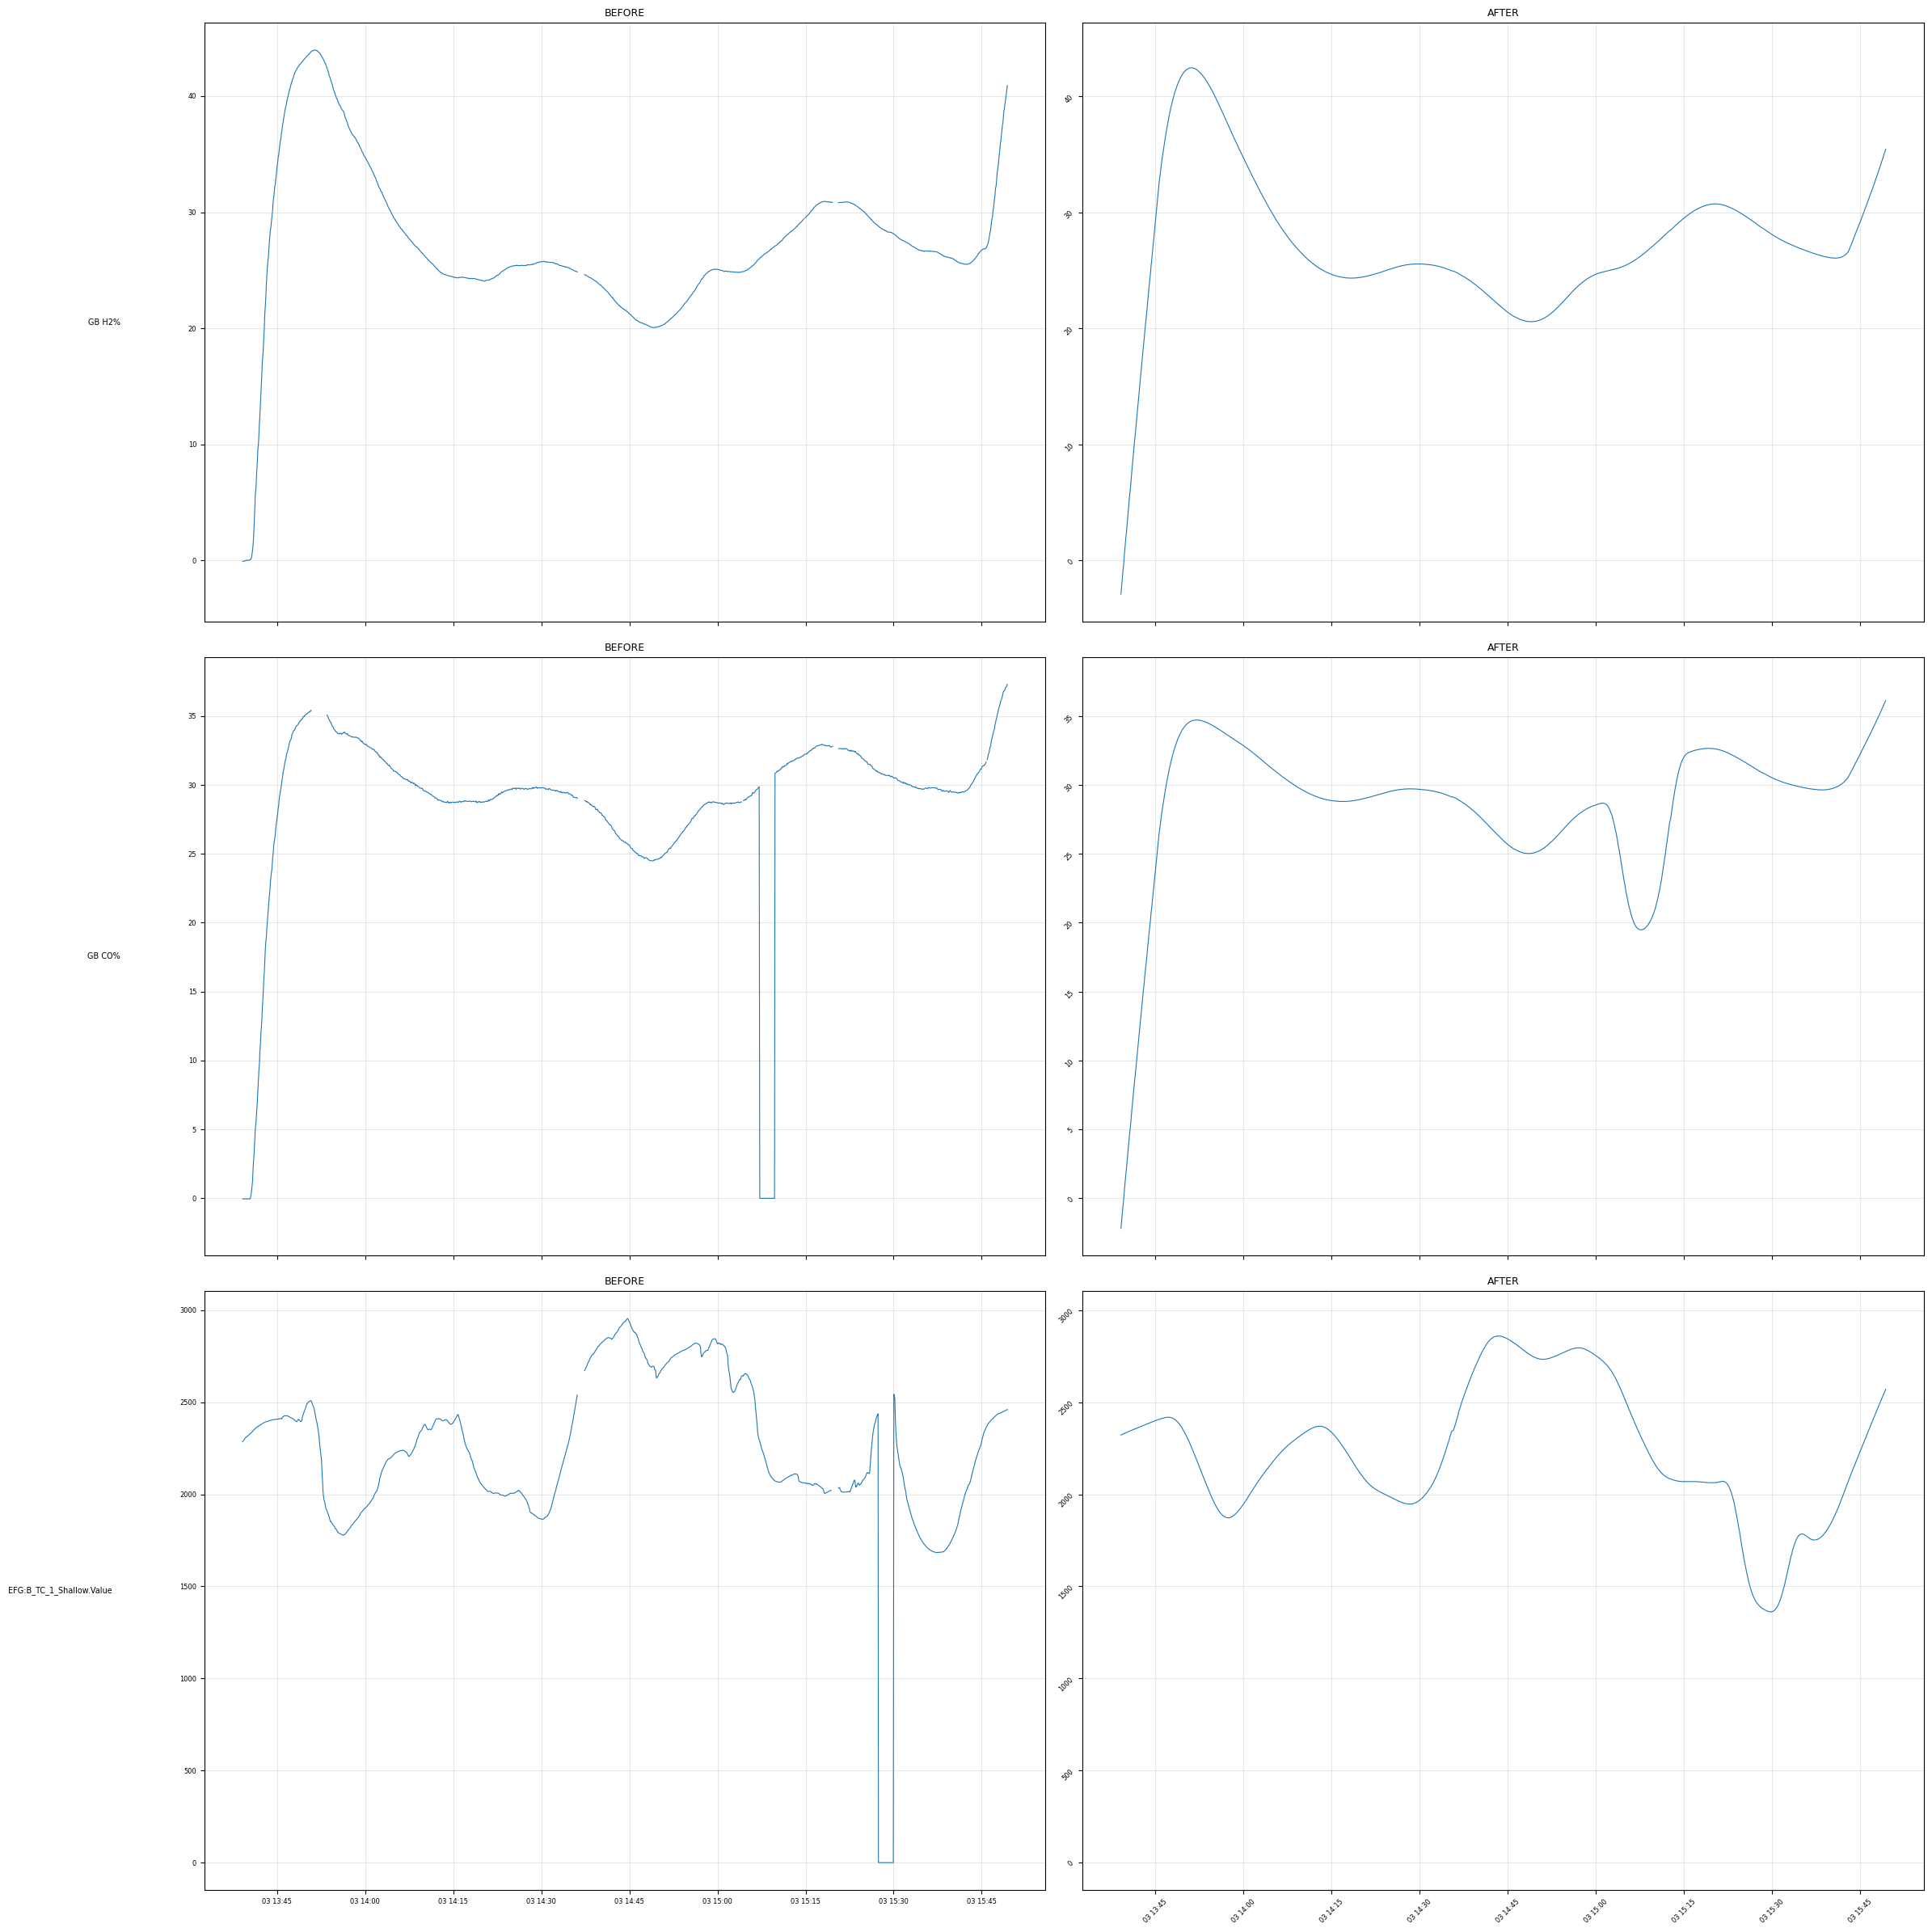

In [2273]:
df_cleaned = clean_all(df_corrupted.copy(), target_cols, scenario_map, verbose=True)

cols_to_plot = [
    col for col in target_cols
    if col not in ['Date', 'Time'] and df_corrupted[col].isna().sum() > 0
]
plot_side_by_side(
    df_before = df_corrupted,
    df_after = df_cleaned,
    cols = cols_to_plot,
    datetime_col = 'datetime',
    figsize_per_row = (24, 8)
)


## Now we will prepare the PyPOTS input

In [2274]:
def run_saits_pipeline(df_train, df_simulated, target_cols, window_size=42):
    # 1) Sort and reset datetime
    for df in (df_train, df_simulated):
        df.sort_values("datetime", inplace=True)
        df.reset_index(drop=True, inplace=True)

    # 2) Normalize
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df_train_scaled = df_train.copy()
    df_sim_scaled = df_simulated.copy()
    df_train_scaled[target_cols] = scaler.fit_transform(df_train_scaled[target_cols])
    df_sim_scaled[target_cols] = scaler.transform(df_sim_scaled[target_cols])

    # 3) Build windowed datasets
    def make_pypots_dataset(df, features, window_size):
        data = df[features].to_numpy()
        n_samples = data.shape[0] - window_size + 1
        X = np.zeros((n_samples, window_size, len(features)))
        for i in range(n_samples):
            X[i] = data[i : i + window_size]
        return X

    X_true = make_pypots_dataset(df_train_scaled, target_cols, window_size)
    X_corr = make_pypots_dataset(df_sim_scaled, target_cols, window_size)
    mask = (~np.isnan(X_corr)).astype(int)

    train_set = {"X": X_corr, "mask": mask}
    val_set = {
    "X": X_true[:X_corr.shape[0]],        # validation is on clean data
    "mask": mask,                         # use corrupted mask
    "X_ori": X_true[:X_corr.shape[0]]     # original clean targets
    }
    # 4) Train SAITS
    saits = SAITS(
        n_steps=window_size,
        n_features=len(target_cols),
        d_model=256, n_layers=2, d_ffn=128,
        n_heads=4, d_k=64, d_v=64,
        batch_size=32, epochs=200,
        optimizer=Adam(lr=1e-3),
        patience=10,
        device=None,
    )
    saits.fit(train_set=train_set, val_set=val_set)

    # 5) Predict
    X_imp = saits.predict(train_set)["imputation"]

    # 6) Rebuild DataFrame from overlapping windows
    def rebuild_dataframe(X_imp, df_base, features, window_size):
        n_rows = X_imp.shape[0] + window_size - 1
        n_feats = len(features)
        values = np.zeros((n_rows, n_feats))
        counts = np.zeros_like(values)
        for i in range(X_imp.shape[0]):
            values[i : i + window_size] += X_imp[i]
            counts[i : i + window_size] += 1
        df_out = pd.DataFrame(values / counts, columns=features)
        df_out["datetime"] = df_base["datetime"].iloc[:n_rows].values
        return df_out

    
    df_pypots_cleaned = rebuild_dataframe(X_imp, df_simulated, target_cols, window_size)
    print("\n--- After SAITS Prediction ---")
    print(df_pypots_cleaned.describe())
    
    # 7) Inverse transform ONLY the output
    df_pypots_cleaned[target_cols] = scaler.inverse_transform(df_pypots_cleaned[target_cols])

    # 8) Clip to original value ranges (safety step)
    for col in target_cols:
        col_vals = df_train[col]
        col_min, col_max = col_vals.min(), col_vals.max()
        df_pypots_cleaned[col] = df_pypots_cleaned[col].clip(lower=col_min, upper=col_max)

    return df_pypots_cleaned


## Analyzing the perfomance of the imputation. We will use the original dataframe and compare it with the dataframe that has gone through our pipeline.

In [2276]:
target_cols = [col for col in target_cols if np.issubdtype(df_corrupted[col].dtype, np.number)]
new_missing_mask = df_corrupted[target_cols].isna()

df_cleaned_aligned = df_cleaned.set_index('datetime').loc[df_corrupted['datetime']].reset_index()

if 'datetime' not in df_RD241203.columns:
    df_RD241203['datetime'] = pd.to_datetime(df_RD241203['Date'] + ' ' + df_RD241203['Time'], format='%m/%d/%Y %I:%M:%S %p')

df_true_aligned = df_RD241203.set_index('datetime').loc[df_corrupted['datetime']].reset_index()

# 🔥 Fix type coercion
for col in target_cols:
    df_true_aligned[col] = pd.to_numeric(df_true_aligned[col], errors='coerce')
    df_cleaned_aligned[col] = pd.to_numeric(df_cleaned_aligned[col], errors='coerce')

# Continue
all_true = []
all_pred = []

for col in target_cols:
    mask = new_missing_mask[col]
    
    true_col = df_true_aligned[col][mask]
    pred_col = df_cleaned_aligned[col][mask]

    valid = ~np.isnan(true_col.values) & ~np.isnan(pred_col.values)
    true_valid = true_col.values[valid]
    pred_valid = pred_col.values[valid]

    all_true.extend(true_valid)
    all_pred.extend(pred_valid)

all_true = np.array(all_true)
all_pred = np.array(all_pred)

mae = mean_absolute_error(all_true, all_pred)
rmse = mean_squared_error(all_true, all_pred)
r2 = r2_score(all_true, all_pred)

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE (Mean Absolute Error): 22.5237
RMSE (Root Mean Squared Error): 2878.6860
R² Score: 0.9969


In [ ]:
# 🔧 Ensure datetime alignment for plotting
df_pots_trimmed["datetime"] = df_trimmed["datetime"]

# 📊 Columns to plot (only those with injected NaNs in trimmed region)
cols_to_plot_saits = [
    col for col in target_cols
    if col in df_trimmed.columns and df_trimmed[col].isna().sum() > 0
]

# ✅ Plot SAITS results: before vs after
plot_side_by_side(
    df_before = df_trimmed,
    df_after = df_pots_trimmed,
    cols = cols_to_plot_saits,
    datetime_col = 'datetime',
    figsize_per_row = (24, 8)
)


In [2278]:
results = []

for col in target_cols:
    mask = new_missing_mask[col]

    true_col = df_true_aligned[col][mask]
    pred_col = df_cleaned_aligned[col][mask]

    valid = ~np.isnan(true_col.values) & ~np.isnan(pred_col.values)
    true_valid = true_col.values[valid]
    pred_valid = pred_col.values[valid]

    if len(true_valid) > 0:
        mae = mean_absolute_error(true_valid, pred_valid)
        rmse = mean_squared_error(true_valid, pred_valid)
        r2 = r2_score(true_valid, pred_valid)
        results.append((col, mae, rmse, r2))

metrics_df = pd.DataFrame(results, columns=['Column', 'MAE', 'RMSE', 'R2'])

metrics_df = metrics_df.sort_values(by='MAE')

print(metrics_df)

                     Column        MAE          RMSE        R2
0                    GB H2%   0.100908      0.010899  0.998771
1                    GB CO%   0.706717      1.347688  0.814308
2  EFG:B_TC_1_Shallow.Value  93.768233  12202.491791  0.864158


## Anomaly Detection

In [2279]:
# Outlier removal function returning a cleaned Series without modifying the original DataFrame

def rolling_med_clean(df, col_name, window, quantile):
    """
    Removes outliers from df[col_name] by:
      1) Computing rolling median over specified window
      2) Calculating absolute deviations from that median
      3) Masking points where deviation >= given quantile threshold
      4) Imputing masked points by averaging nearest valid neighbors

    Does NOT modify the original df. Instead returns a new pandas.Series.

    Parameters
    ----------
    df : pandas.DataFrame
        Source DataFrame containing the column to clean.
    col_name : str
        Name of the numeric column to process.
    window : int
        Rolling window size for median calculation.
    quantile : float
        Quantile (0 < quantile < 1) to determine outlier cutoff on absolute deviations.

    Returns
    -------
    pandas.Series
        A new Series of the same length as df with the same name as col_name.
    """
    # 1) Rolling median
    med_vals = df[col_name].rolling(window=window, center=True, min_periods=1).median()

    # 2) Absolute deviation
    med_dif = (df[col_name] - med_vals).abs()

    # 3) Mask outliers beyond the quantile
    threshold = med_dif.quantile(quantile)
    mask = med_dif >= threshold

    # 4) Build cleaned Series, initializing with original values
    cleaned = df[col_name].copy()
    valid_idx = cleaned.index[~mask]

    # Impute each outlier by nearest valid neighbors
    for idx in cleaned.index[mask]:
        prev_valid = valid_idx[valid_idx < idx]
        next_valid = valid_idx[valid_idx > idx]
        if len(prev_valid) and len(next_valid):
            cleaned.at[idx] = (
                df.at[prev_valid.max(), col_name] + 
                df.at[next_valid.min(), col_name]
            ) / 2
        elif len(prev_valid):
            cleaned.at[idx] = df.at[prev_valid.max(), col_name]
        elif len(next_valid):
            cleaned.at[idx] = df.at[next_valid.min(), col_name]

    # Rename the Series to indicate outliers removed
    cleaned.name = f"{col_name}"
    return cleaned

In [2280]:
def second_diff_clean(df: pd.DataFrame, col: str, quantile: float) -> pd.Series:
    """
    Clean outliers in df[col] based on centered second differences.

    Steps:
      1. Compute first differences d1 and d2.
      2. Compute centered second difference sec = y.shift(-1) - 2*y + y.shift(1).
      3. Where slopes change sign (d1 * d2 < 0), sec_diff = abs(sec), else 0.
      4. Determine threshold = sec_diff.quantile(quantile).
      5. Mask points where sec_diff > threshold.
      6. Initialize cleaned series with original values.
      7. Impute each masked outlier using nearest valid neighbors:
         - If both previous and next valid exist, impute their mean.
         - Otherwise, use whichever neighbor exists.
      8. Return the cleaned series.
    """
    y = df[col]
    # First differences
    d1 = y - y.shift(1)
    d2 = y.shift(-1) - y
    # Centered second difference
    sec = y.shift(-1) - 2 * y + y.shift(1)

    # Absolute second difference when slope changes sign, else 0
    sec_diff = pd.Series(
        np.where(d1 * d2 <= 0, sec.abs(), 0),
        index=df.index
    )

    # Compute quantile threshold and mask outliers
    thresh = sec_diff.quantile(quantile)
    mask = sec_diff > thresh

    # Initialize cleaned series
    cleaned = y.copy()
    valid_idx = cleaned.index[~mask]

    # Impute each outlier by nearest valid neighbors
    for idx in cleaned.index[mask]:
        prev_valid = valid_idx[valid_idx < idx]
        next_valid = valid_idx[valid_idx > idx]
        if len(prev_valid) and len(next_valid):
            cleaned.at[idx] = (
                df.at[prev_valid.max(), col] + df.at[next_valid.min(), col]
            ) / 2
        elif len(prev_valid):
            cleaned.at[idx] = df.at[prev_valid.max(), col]
        elif len(next_valid):
            cleaned.at[idx] = df.at[next_valid.min(), col]
    
    # Ensure the series has the original name
    cleaned.name = col
    return cleaned

In [2281]:
column_filter = ['Date', 'Time', 'EFG Air Flow Rate lb/hr', 'Primary O2 Flow Rate lb/hr',
                    'EFG System Pressure psi',
                    'Slurry Flow Rate lb/hr',
                    'EFG:EFG_Oxygen_Pressure_1.Value',
                    'EFG:EFG_Oxygen_Pressure_2.Value',
                     'Analyzer 2 CO2 %',
                     'Analyzer 3 O2 %', 
                    'Analyzer 3 CO2%',
                     'ABB CH4',
                    'ABB CO',
                    'ABB CO2',
                    'ABB O2',
                    'GB O2%',
                    'GB CO2%',
                    'GB CO%',
                    'GB CH4%',
                    'GB H2%',
                    'GB C2H4%',
                    'GB C2H2%',
                    'GB LHV [MJ/Nm3]',
                    'EFG:B_TC_1_Shallow.Value',
                    'EFG:B_TC_4_Shallow.Value']

In [2282]:
pd.set_option('display.max_rows', None)

In [2283]:
rd241203 = pd.read_csv("Gasifier Data Sets/RD241203.csv")
rd241205 = pd.read_csv("Gasifier Data Sets/RD241205.csv")
rd250122 = pd.read_csv("Gasifier Data Sets/RD250122.csv")

In [2284]:
dfs = [rd241203, rd241205, rd250122]
for df in dfs:
    if 'Moyno Flow Rate lb/hr' in df.columns:
        df.rename(columns={'Moyno Flow Rate lb/hr': 'Slurry Flow Rate lb/hr'}, inplace=True)

In [2285]:
filtered_dfs = [df[column_filter] for df in dfs]

In [2288]:
def plot_all_fields(df, title):
    '''
    Plots each existing non-time column in a compact 3-column grid of subplots vs. 'datetime'.
    '''
    time_column = 'datetime'
    
    fields = ['EFG Air Flow Rate lb/hr', 'Primary O2 Flow Rate lb/hr',
              'EFG System Pressure psi', 'Slurry Flow Rate lb/hr',
              'EFG:EFG_Oxygen_Pressure_1.Value', 'EFG:EFG_Oxygen_Pressure_2.Value',
              'Analyzer 2 CO2 %', 'Analyzer 3 O2 %', 'Analyzer 3 CO2%',
              'ABB CH4', 'ABB CO', 'ABB CO2', 'ABB O2',
              'GB O2%', 'GB CO2%', 'GB CO%', 'GB CH4%',
              'GB H2%', 'GB C2H4%', 'GB C2H2%',
              'GB LHV [MJ/Nm3]', 'EFG:B_TC_1_Shallow.Value', 'EFG:B_TC_4_Shallow.Value']

    # 🔥 Only plot fields that actually exist
    fields = [f for f in fields if f in df.columns]

    num_fields = len(fields)
    ncols = 5
    nrows = math.ceil(num_fields / ncols)
    height_per_row = 1.2  # slightly larger

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(15, height_per_row * nrows),
        sharex=False
    )

    axes = axes.flatten()

    for i, field in enumerate(fields):
        ax = axes[i]
        ax.plot(df[time_column], df[field])
        ax.set_title(field, fontsize=8, pad=8)
        ax.tick_params(labelbottom=False, labelsize=7)

    for j in range(len(fields), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    fig.subplots_adjust(hspace=0.75, wspace=0.4)
    plt.show()


In [2289]:
print(df.columns.tolist())


['Date', 'Time', 'EFG Air Flow Rate lb/hr', 'EFG Gas Flow Rate lb/hr', 'Primary O2 Flow Rate lb/hr', 'Secondary O2 Flow Rate lb/hr', 'EFG System Pressure psi', 'EFG Reactor dP inH2O', 'Slurry Flow Rate lb/hr', 'EFG:EFG_Oxygen_Pressure_1.Value', 'EFG:EFG_Oxygen_Pressure_2.Value', 'EFG:Ballast_Reading.Value', 'EFG:Ballast_SP.Value', 'EFG:HOB_Fuel_Reading.Value', 'EFG:HOB_Fuel_SP.Value', 'EFG:HOB_CW_In.Value', 'EFG:Hot_Hold_HSR', 'EFG:HSR', 'EFG:HOB_Peeper.State', 'EFG:HOB_Op', 'EFG:EFG_Reactor_Top_1.Value', 'EFG:EFG_Reactor_Top_2.Value', 'EFG:EFG_Reactor_Top_3.Value', 'Injector Cooling Water Outlet Temp F', 'Analyzer 2 CO2 %', 'Analyzer 2 CO %', 'Analyzer 3 O2 %', 'Analyzer 3 CO2%', 'ABB CH4', 'ABB CO', 'ABB CO2', 'ABB O2', 'GB O2%', 'GB CO2%', 'GB CO%', 'GB CH4%', 'GB H2%', 'GB C2H4%', 'GB C2H2%', 'GB LHV [MJ/Nm3]', 'Afterburner Air Flow Rate lb/hr', 'Afterburner Natural Gas Flow Rate lb/hr', 'Afterburner Sec 1 Temp F', 'Afterburner Sec 2 Temp F', 'Afterburner Sec 3 Temp F', 'Afterburne

In [2290]:
# titles = ['smooth rd241203', 'smooth rd241205', 'smooth rd250122']
# i = 0
# for sdf in smoothed_dfs:
#     title = titles[i]
#     plot_all_fields(sdf, title)
#     i+=1
    

## Comparing different performances depending on which method we use to run through the pipeline.

**In this part of the notebook we will run the entire pipeline using a dirty data set that contains several missing values in several features. Then, we will use basic missing value logic such as forward filling, mean filing and KNN. Then, we will run the data frame through the anomaly detection part of the pipeline. Lastly, we will use summary statistics to compare the performance after the dataframe has run through the entire pipeline. Then, we will once again run our dataframe but this time instead of using basic missing value techniques we will use PyPOTS and neural networks to fill in the missing values. Then, we will run the remaining of the pipeline and use summary statistics to show that our neural network approach perform better.**

In [2291]:
# ✅ FINAL CORRECTIONS TO MAKE THE PIPELINE CONSISTENT
# Update the two functions so they *use the passed-in corrupted data*, not reinject it internally.

def run_basic_pipeline(df_raw, df_corrupted, missing_mask, scenario_map):
    # Step 1: Use already injected corrupted data
    df_basic = clean_all(df_corrupted.copy(), target_cols, scenario_map)

    # Step 2: Align
    common_dt = df_corrupted["datetime"]
    df_true_aligned = df_raw.set_index("datetime").loc[common_dt].reset_index()
    df_pred_aligned = df_basic.set_index("datetime").loc[common_dt].reset_index()
    mask_aligned = missing_mask.set_index(df_corrupted["datetime"]).loc[common_dt].reset_index(drop=True)

    # Step 3: Evaluate
    metrics_basic = evaluate_imputation(df_true_aligned, df_pred_aligned, mask_aligned, target_cols)
    return df_pred_aligned, metrics_basic

def run_pypots_pipeline(df_raw, df_corrupted, missing_mask, scenario_map):
    # Step 1: Use already injected corrupted data
    print("\n--- After injecting missing values ---")
    print("Total NaNs in df_corrupted:")
    print(df_corrupted.isna().sum())
    print("Total Missing Mask True counts:")
    print(missing_mask.sum())

    # Step 2: Impute with SAITS
    window_size = 56
    df_pots = run_saits_pipeline(df_raw, df_corrupted, target_cols, window_size)

    # Step 3: Align
    df_simulated = df_corrupted.sort_values("datetime").reset_index(drop=True)
    df_trimmed = df_simulated.iloc[window_size - 1:].reset_index(drop=True)
    df_pots = df_pots.iloc[:len(df_trimmed)].reset_index(drop=True)
    df_pots["datetime"] = df_trimmed["datetime"].values

    print("\n--- After aligning df_trimmed and df_pots ---")
    print("Datetime aligned:", (df_pots['datetime'].values == df_trimmed['datetime'].values).all())

    df_true_aligned = df_raw.set_index("datetime").loc[df_trimmed["datetime"]].reset_index()
    mask_aligned = df_trimmed[target_cols].isna()

    # Step 4: Evaluate
    metrics_pots = evaluate_imputation(df_true_aligned, df_pots, mask_aligned, target_cols)
    return df_pots, metrics_pots


**Basic pipeline**

In [2294]:
# ✅ Inject missing values ONCE and share across both pipelines
df_corrupted, missing_mask, scenario_map = inputing_missing_values(df_useful, df_RD241203)

# ✅ Run both pipelines using the SAME corrupted data
df_basic_cleaned, basic_metrics = run_basic_pipeline(df_RD241203, df_corrupted, missing_mask, scenario_map)
df_pypots_cleaned, saits_metrics = run_pypots_pipeline(df_RD241203, df_corrupted, missing_mask, scenario_map)

# ✅ Print comparison
print("📊 Basic Pipeline Metrics:")
print(basic_metrics)
print("📈 SAITS Pipeline Metrics:")
print(saits_metrics)



--- Injecting Missing Data ---
[Short Glitch] Injected NaNs at rows 146-148 in column 'GB CO%'
[Short Glitch] Injected NaNs at rows 1194-1196 in column 'EFG:B_TC_1_Shallow.Value'
[Short Glitch] Injected NaNs at rows 1012-1014 in column 'EFG:B_TC_1_Shallow.Value'
[Network Malfunction] Dropped rows 681-683
[Network Malfunction] Dropped rows 671-673
[Maintenance Pause] Injected 0s at rows 1283-1313 in 'GB H2%'
[Maintenance Pause] Injected 0s at rows 1042-1072 in 'EFG:B_TC_1_Shallow.Value'
[Maintenance Pause] Injected NaNs at rows 140-170 in 'GB CO%'
[Sensor Error] Inserted placeholder 1000000.0 at row 1502 in 'GB CO%'
[Sensor Error] Inserted placeholder 1000000.0 at row 1133 in 'GB CO%'
[Sensor Error] Inserted placeholder 1000000.0 at row 1172 in 'GB CO%'
[Time Desync] Row 1107 datetime ← row 1106
[Time Desync] Row 792 datetime ← row 793
[Time Desync] Row 1295 datetime ← row 1296
[Catastrophic Event] Injected NaNs at rows 1191-1201 in ['EFG:B_TC_1_Shallow.Value' 'GB CO%' 'GB H2%']
[Catas

C:\Users\randy\AppData\Local\Temp\ipykernel_5516\4074044224.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
2025-04-29 17:24:08 [INFO]: No given device, using default device: cpu
2025-04-29 17:24:08 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-04-29 17:24:08 [INFO]: Using customized MAE as the training loss function.
2025-04-29 17:24:08 [INFO]: Using customized MSE as the validation metric function.
2025-04-29 17:24:08 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,321,670


[Final Sweep] ffill + bfill…

--- Evaluation ---
Number of points evaluated: 106
True values sample: [24.874 24.87  24.814 24.788 24.784]
Predicted values sample: [25.00651977 24.98608675 24.87885729 24.85639751 24.83359577]

--- After injecting missing values ---
Total NaNs in df_corrupted:
EFG Air Flow Rate lb/hr                        0
EFG Gas Flow Rate lb/hr                        0
Primary O2 Flow Rate lb/hr                     0
Secondary O2 Flow Rate lb/hr                   0
EFG System Pressure psi                        0
EFG Reactor dP inH2O                           0
Moyno Flow Rate lb/hr                          0
EFG:EFG_Oxygen_Pressure_1.Value                0
EFG:EFG_Oxygen_Pressure_2.Value                0
EFG:Ballast_Reading.Value                      0
EFG:Ballast_SP.Value                           0
EFG:HOB_Fuel_Reading.Value                     0
EFG:HOB_Fuel_SP.Value                          0
EFG:HOB_CW_In.Value                            0
EFG:Hot_Hold_HSR     

2025-04-29 17:24:12 [INFO]: Epoch 001 - training loss (MAE): 233.7293, validation MSE: 0.0000
2025-04-29 17:24:16 [INFO]: Epoch 002 - training loss (MAE): 225.9870, validation MSE: 0.0000
2025-04-29 17:24:21 [INFO]: Epoch 003 - training loss (MAE): 233.3541, validation MSE: 0.0000
2025-04-29 17:24:25 [INFO]: Epoch 004 - training loss (MAE): 259.5843, validation MSE: 0.0000
2025-04-29 17:24:29 [INFO]: Epoch 005 - training loss (MAE): 244.8603, validation MSE: 0.0000
2025-04-29 17:24:33 [INFO]: Epoch 006 - training loss (MAE): 249.7287, validation MSE: 0.0000
2025-04-29 17:24:37 [INFO]: Epoch 007 - training loss (MAE): 238.8530, validation MSE: 0.0000
2025-04-29 17:24:41 [INFO]: Epoch 008 - training loss (MAE): 244.5194, validation MSE: 0.0000
2025-04-29 17:24:45 [INFO]: Epoch 009 - training loss (MAE): 253.8395, validation MSE: 0.0000
2025-04-29 17:24:49 [INFO]: Epoch 010 - training loss (MAE): 259.7330, validation MSE: 0.0000
2025-04-29 17:24:53 [INFO]: Epoch 011 - training loss (MAE):


--- After SAITS Prediction ---
            GB H2%         GB CO%  EFG:B_TC_1_Shallow.Value  \
count  1545.000000    1545.000000               1545.000000   
mean     -0.086221     381.660140                 -0.133760   
min      -4.078646      -5.773260                 -6.843095   
25%      -0.436695      -0.118075                 -0.804664   
50%      -0.228205       0.083208                 -0.126693   
75%       0.355837       0.479090                  0.662414   
max       2.481724  196559.562500                  2.027150   
std       1.152414    8655.838081                  1.384455   

                            datetime  
count                           1545  
mean   2024-12-03 14:44:16.806472448  
min              2024-12-03 13:39:07  
25%              2024-12-03 14:11:34  
50%              2024-12-03 14:44:31  
75%              2024-12-03 15:16:55  
max              2024-12-03 15:49:22  
std                              NaN  

--- After aligning df_trimmed and df_pots ---
Da

**Comparing side by side**

In [2295]:
comparison_df = pd.DataFrame([
    {"Method": "Basic",  **basic_metrics},
    {"Method": "SAITS",  **saits_metrics},
])
print("\nComparison of Imputation Methods:\n")
print(comparison_df)



Comparison of Imputation Methods:

  Method        MAE        RMSE        R2
0  Basic  25.653905   79.397161  0.993981
1  SAITS  84.740378  226.243870  0.951946


In [2299]:
# 1) Recompute your trimmed data exactly as in your pipeline
window_size = 56
df_trimmed = (
    df_corrupted
    .sort_values("datetime")
    .reset_index(drop=True)
    .iloc[window_size - 1:]
    .reset_index(drop=True)
)

# 2) Realign true & SAITS outputs
df_true_trimmed = (
    df_RD241203
    .set_index("datetime")
    .loc[df_trimmed["datetime"]]
    .reset_index()
)
df_pots_trimmed = df_pypots_cleaned.iloc[:len(df_trimmed)].reset_index(drop=True)

# 3) Build a boolean mask of where df_trimmed was NaN
new_missing_mask_saits = df_trimmed[target_cols].isna().reset_index(drop=True)

# 4) Quick sanity checks
print(f"Trimmed length: {len(df_trimmed)}")
print(f" True aligned length: {len(df_true_trimmed)}")
print(f" SAITS  aligned length: {len(df_pots_trimmed)}\n")
print("Missing values per column in trimmed region:")
print(new_missing_mask_saits.sum())
print()


Trimmed length: 1490
 True aligned length: 1490
 SAITS  aligned length: 1490

Missing values per column in trimmed region:
GB H2%                      22
GB CO%                      53
EFG:B_TC_1_Shallow.Value    28
dtype: int64



Final target columns: ['GB H2%', 'GB CO%', 'EFG:B_TC_1_Shallow.Value']


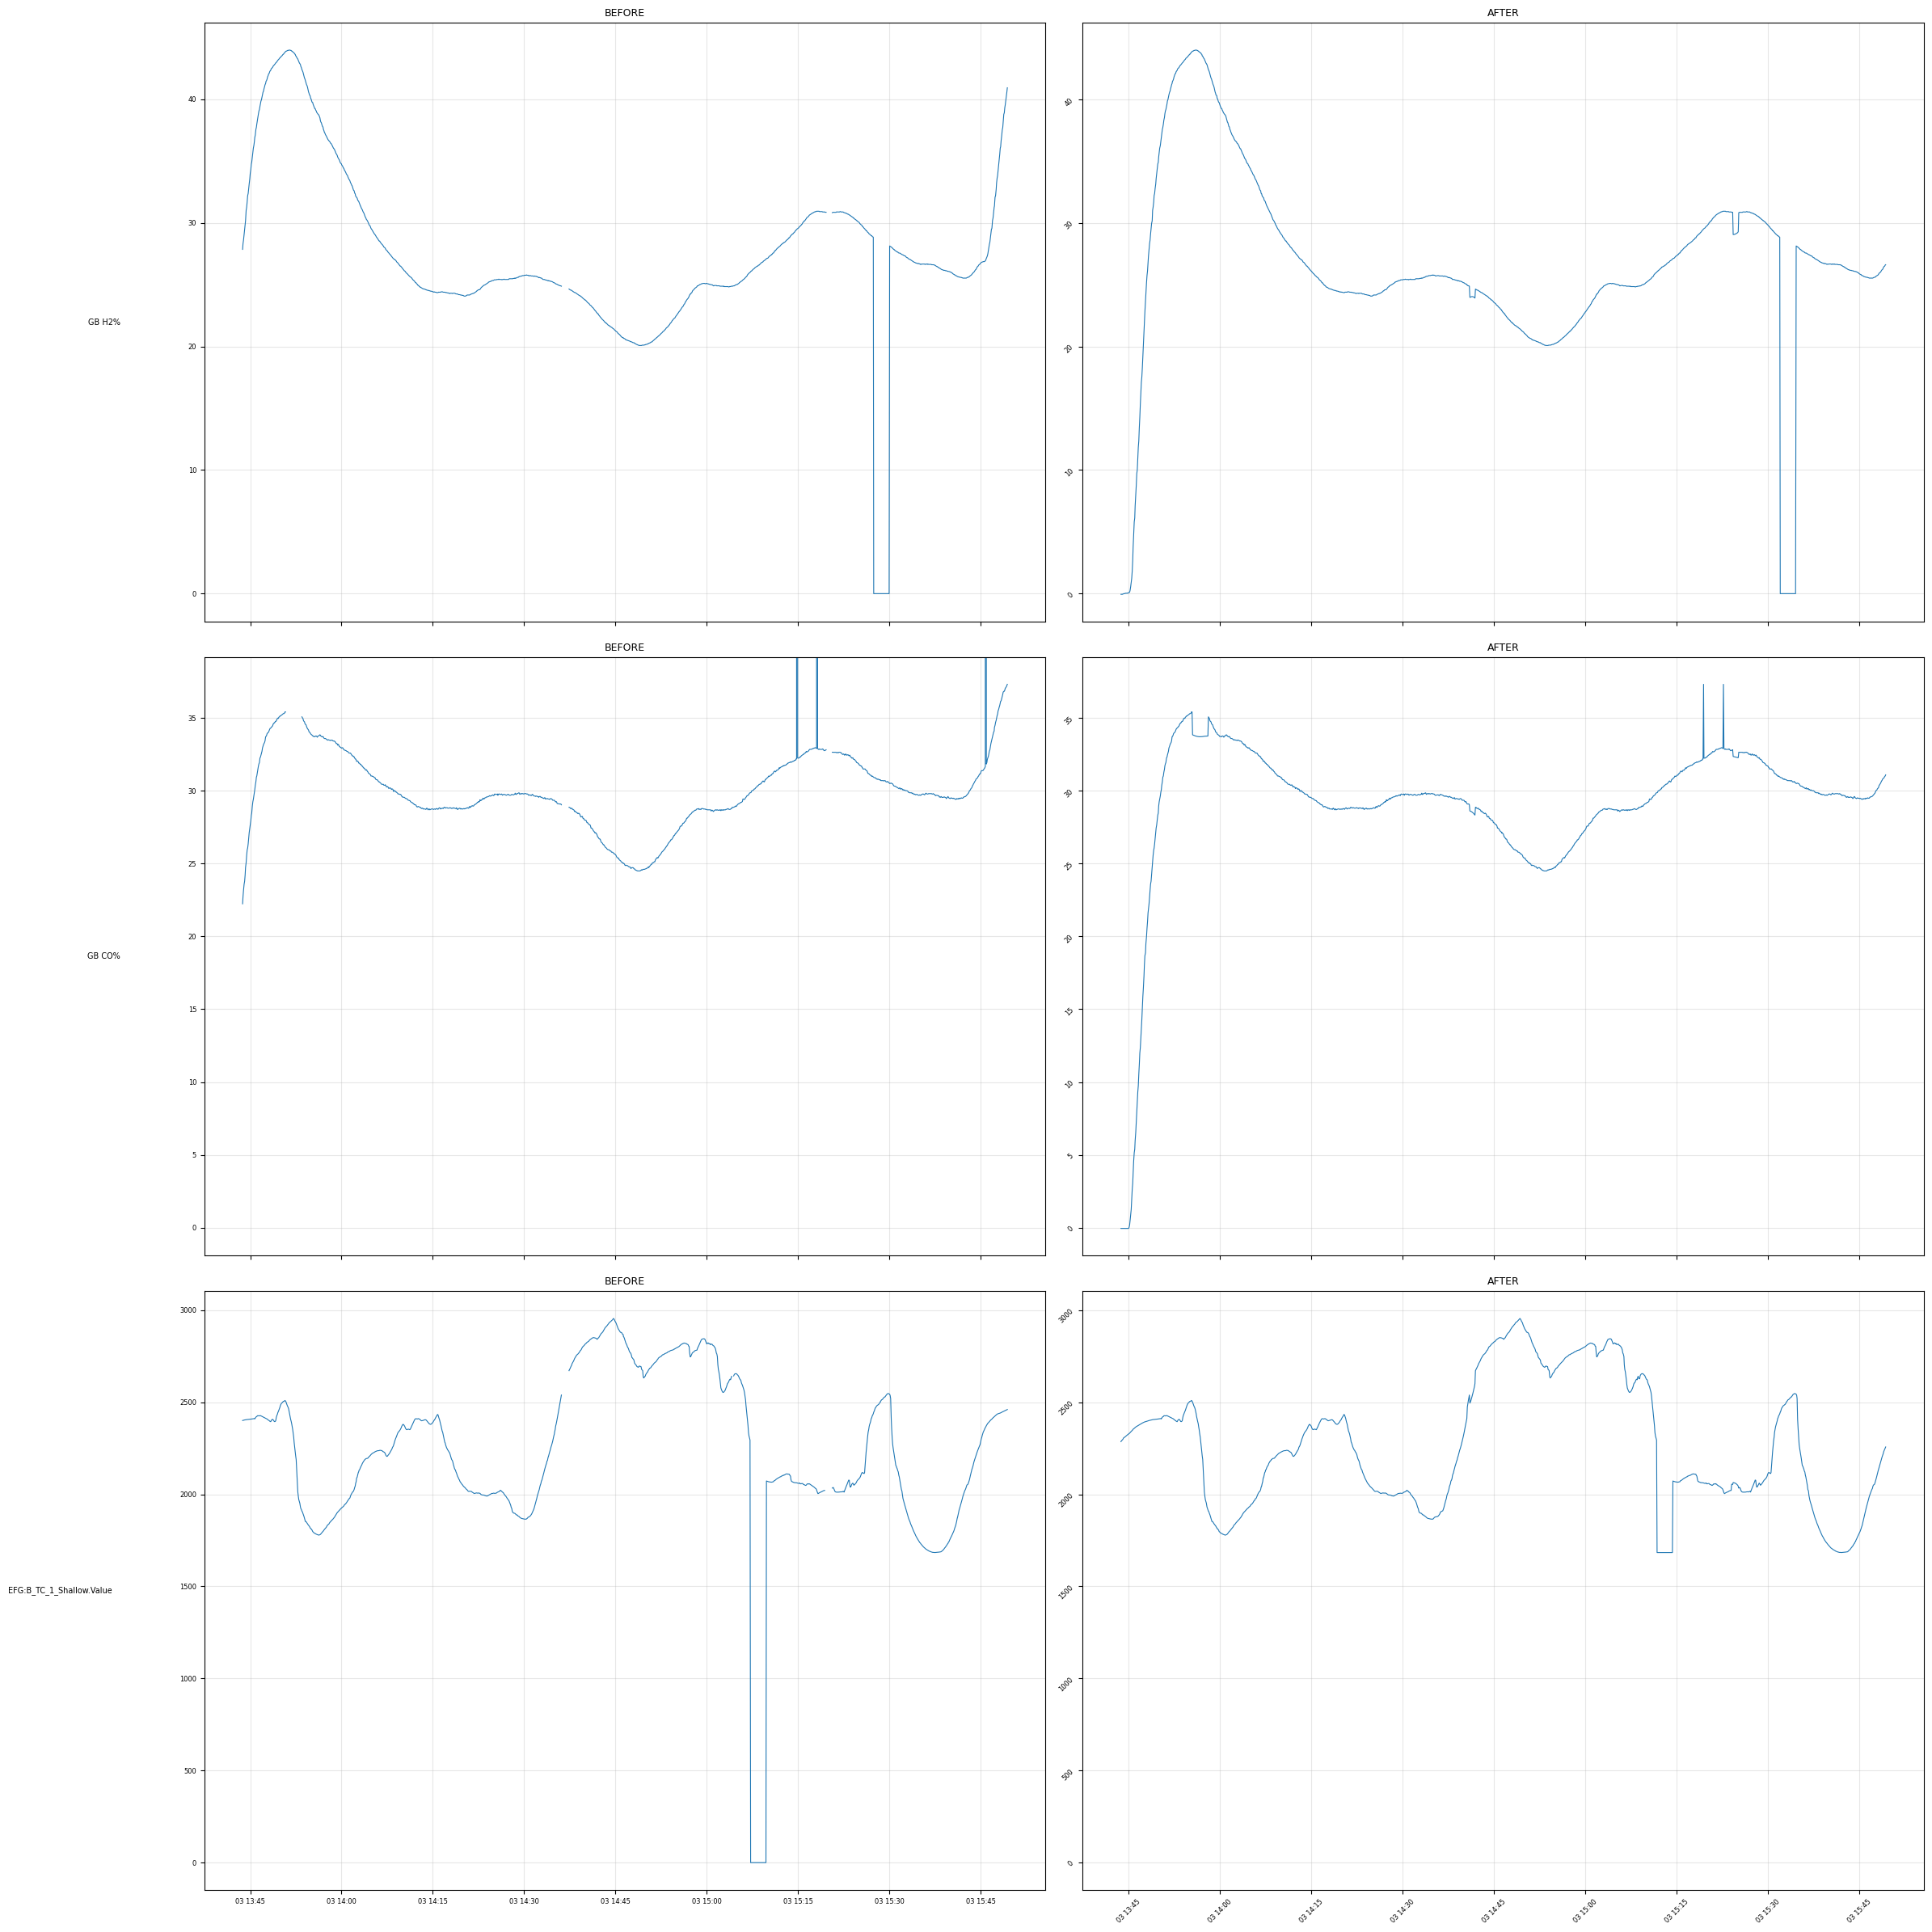

In [2300]:
# 🔧 Ensure datetime alignment for plotting
df_pots_trimmed["datetime"] = df_trimmed["datetime"]

# 📊 Columns to plot (only those with injected NaNs in trimmed region)
cols_to_plot_saits = [
    col for col in target_cols
    if col in df_trimmed.columns and df_trimmed[col].isna().sum() > 0
]

# ✅ Plot SAITS results: before vs after
plot_side_by_side(
    df_before = df_trimmed,
    df_after = df_pots_trimmed,
    cols = cols_to_plot_saits,
    datetime_col = 'datetime',
    figsize_per_row = (24, 8)
)


In [2296]:
results = []

print("📊 Per-column metrics for the BASIC pipeline (evaluated only on missing positions):\n")

for col in target_cols:
    mask = new_missing_mask[col]
    true_col = df_true_aligned[col][mask]
    pred_col = df_cleaned_aligned[col][mask]

    valid = ~np.isnan(true_col.values) & ~np.isnan(pred_col.values)
    true_valid = true_col.values[valid]
    pred_valid = pred_col.values[valid]

    if len(true_valid) > 1:
        mae = mean_absolute_error(true_valid, pred_valid)
        rmse = mean_squared_error(true_valid, pred_valid) ** 0.5
        r2 = r2_score(true_valid, pred_valid)
        results.append((col, mae, rmse, r2))
        print(f"Column: {col}")
        print(f"   MAE  = {mae:.4f}")
        print(f"   RMSE = {rmse:.4f}")
        print(f"   R²   = {r2:.6f}")
        print("-" * 40)

# Build dataframe
metrics_df = pd.DataFrame(results, columns=['Column', 'MAE', 'RMSE', 'R2'])
metrics_df = metrics_df.sort_values(by='MAE')

print("\n📋 Sorted summary (lowest MAE to highest):\n")
from IPython.display import display
display(metrics_df)


📊 Per-column metrics for the BASIC pipeline (evaluated only on missing positions):

Column: GB H2%
   MAE  = 0.1009
   RMSE = 0.1044
   R²   = 0.998771
----------------------------------------
Column: GB CO%
   MAE  = 0.7067
   RMSE = 1.1609
   R²   = 0.814308
----------------------------------------
Column: EFG:B_TC_1_Shallow.Value
   MAE  = 93.7682
   RMSE = 110.4649
   R²   = 0.864158
----------------------------------------

📋 Sorted summary (lowest MAE to highest):



,Column,MAE,RMSE,R2
0,GB H2%,0.100908,0.104400,0.998771
1,GB CO%,0.706717,1.160899,0.814308
2,EFG:B_TC_1_Shallow.Value,93.768233,110.464889,0.864158


In [2297]:
# 1) Recompute your trimmed data exactly as in your pipeline
window_size = 56
df_trimmed = (
    df_corrupted
    .sort_values("datetime")
    .reset_index(drop=True)
    .iloc[window_size - 1:]
    .reset_index(drop=True)
)

# 2) Realign true & SAITS outputs
df_true_trimmed = (
    df_RD241203
    .set_index("datetime")
    .loc[df_trimmed["datetime"]]
    .reset_index()
)
df_pots_trimmed = df_pypots_cleaned.iloc[:len(df_trimmed)].reset_index(drop=True)

# 3) Build a boolean mask of where df_trimmed was NaN
new_missing_mask_saits = df_trimmed[target_cols].isna().reset_index(drop=True)

# 4) Quick sanity checks
print(f"Trimmed length: {len(df_trimmed)}")
print(f" True aligned length: {len(df_true_trimmed)}")
print(f" SAITS  aligned length: {len(df_pots_trimmed)}\n")
print("Missing values per column in trimmed region:")
print(new_missing_mask_saits.sum())
print()

# 5) Per-column metrics
results_saits = []
print("📈 SAITS per-column metrics (on originally missing positions):\n")
for col in target_cols:
    missing_count = new_missing_mask_saits[col].sum()
    print(f"{col:40s} → {missing_count:3d} missing")
    if missing_count > 0:
        true_vals = df_true_trimmed.loc[new_missing_mask_saits[col], col]
        pred_vals = df_pots_trimmed.loc[new_missing_mask_saits[col], col]
        mae   = mean_absolute_error(true_vals, pred_vals)
        rmse  = mean_squared_error(true_vals, pred_vals, squared=False)
        r2    = r2_score(true_vals, pred_vals)
        results_saits.append((col, mae, rmse, r2))
        print(f"   MAE  = {mae:.4f}")
        print(f"   RMSE = {rmse:.4f}")
        print(f"   R²   = {r2:.6f}\n")

# 6) Build and display a DataFrame of results
import pandas as pd
metrics_saits_df = (
    pd.DataFrame(results_saits, columns=['Column','MAE','RMSE','R2'])
      .sort_values('MAE')
      .reset_index(drop=True)
)

print("📋 Sorted summary (lowest MAE first):")
display(metrics_saits_df)

Trimmed length: 1490
 True aligned length: 1490
 SAITS  aligned length: 1490

Missing values per column in trimmed region:
GB H2%                      22
GB CO%                      53
EFG:B_TC_1_Shallow.Value    28
dtype: int64

📈 SAITS per-column metrics (on originally missing positions):

GB H2%                                   →  22 missing
   MAE  = 0.9474
   RMSE = 0.9554
   R²   = 0.900212

GB CO%                                   →  53 missing
   MAE  = 1.4347
   RMSE = 1.8050
   R²   = 0.515230

EFG:B_TC_1_Shallow.Value                 →  28 missing
   MAE  = 308.2634
   RMSE = 433.9188
   R²   = -1.036559

📋 Sorted summary (lowest MAE first):


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Column,MAE,RMSE,R2
0,GB H2%,0.947364,0.955428,0.900212
1,GB CO%,1.434736,1.804987,0.515230
2,EFG:B_TC_1_Shallow.Value,308.263426,433.918812,-1.036559
